#Numba

In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.2/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.2/nvvm-prev/lib64/libnvvm.so"

In [ ]:
from numba import jit

#Test cases
https://github.com/cshen6/GraphEmd/blob/main/Matlab/simGenerate.m

  Case 10, 11, 20, 21


#Package Section

In [ ]:
import numpy as np
import copy
import math

#Classes and functions

## Functions with Numba

In [ ]:
class Model:
  def __init__(self, n):
    """
      Initialize the class
      n: the number of nodes
      d: initialize the number of class categories/communities to None
      X: initialize the adjacency matrix or edge list to None
      Y: initialize the classes/labels to None
    """
    self.n = n
    self.d = None
    self.X = None
    self.Y = None
    
  def summary(self):
    """
      print the adjacency matrix and Labels
    """
    info = self.info
    n = self.n
    d = self.d
    Y = self.Y
    X = self.X
    if type(Y) == np.ndarray:
      items = (
          ("Info:", info),
          ("n:", type(n), n),
          ("d:", type(d), d),                    
          ("X:", X.shape, X),
          ("Y:", Y.shape, Y),
      )
      for item in items:
        for i in item:
          print(i)
    else:
      print("X: None", "Y: None", sep='\n')
  
  def gety(self, pp):
    """
      Get Labels
      The class categories/communities start from 0
      pp from the input is used for sampling
        pp:  [p1, p2, ..., pn]
        sum(pp) == 1
      tt is a list of ramdonly assigned number to the samples, 
        from unifrom distribution over [0,1)
        tt = [tt1, tt2, ..., ttn] 
      label is given based on tt:
        if tt1 < p1 => label_1 = 0
        if p1 < tt1 < (p2+p1) => label_1 = 1
        ...... 
    """
    np.random.seed(2)
    
    n = self.n
    Y = np.zeros((n,1), dtype=int)
    
    # Create n*1 array from a uniform distribution over [0, 1).
    tt = np.random.rand(n,1) 
    # get thresholds for the labels(the indices)
    thres = [sum(pp[:i+1]) for i in range(len(pp))]
    
    # assgin labels based on the thredsholds, see explaination in docstrings
    for i in range(len(tt)):
      for j in range(len(thres)-1, -1, -1):
        if tt[i] < thres[j]:
          Y[i,0] = j
    
    return Y

  def SBM(self, d, pp, Bl):
    """
      SBM: Stochastic Block Model 
      pp is used for generating labels(classes) -- the input for gety()
      d is total label number. Intotal, d different labels.
      Bl is a d*d matrix. Bl[i,j] indicates the probability of a edge between 
        classes(labels) i and j

      Dis is the n*n matrix, Dis[i,j] indicates the connection between vertex i
      and vertex j, with the probability Bl[i_label,j_label]
       
    """ 
    sbm = copy.deepcopy(self)
    sbm.name = "SBM"
    n = sbm.n
    Y = self.gety(pp)  

    Dis = np.zeros((n,n), dtype=int)
    for i in range(n):
      Dis[i,i] = 0 # assign diagonal 0
      for j in range(i+1,n):
        Dis[i,j] = int(np.random.rand() < Bl[Y[i], Y[j]])
        Dis[j,i] = Dis[i,j]
    
    sbm.X = Dis
    sbm.Y = Y
    sbm.d = d

    return sbm

  def DC_SBM(self, d, pp, Bl):
    """
      DC-SBM: Degree corrected Stochastic Block Model  
      pp is used for generating labels(classes) -- the input for gety()
      d is total label number. In total, d different labels.
      Bl is a d*d matrix. Bl[i,j] indicates the probability between 
        classes(labels) i and j
      
      theta is the n*1 array, each element contains the degree of a vertex(node).

      Dis is the n*n matrix, Dis[i,j] indicates the connection between vertex i
      and vertex j, with the probability theta[i]*theta[j]*Bl[i_label,j_label]

    """

    dcsbm = copy.deepcopy(self)
    dcsbm.name = "DC-SBM" 

    n = dcsbm.n
    Y = self.gety(pp)

    # theta is the n*1 array, from beta distribution with a=1, b=4
    theta = np.random.beta(1,4, (n,1)) 

    Dis = np.zeros((n,n), dtype=int)
    for i in range(n):
      Dis[i,i] = 0 # assign diagonal 0
      for j in range(i+1,n):
        Dis[i,j] = int(np.random.rand() < theta[i]*theta[j]*Bl[Y[i], Y[j]])
        Dis[j,i] = Dis[i,j]   
    
    dcsbm.X = Dis
    dcsbm.Y = Y
    dcsbm.d = d
    return dcsbm

  def DC_SBM_edg_list(self, d, pp, Bl):
      """
        DC-SBM: Degree corrected Stochastic Block Model  
        pp is used for generating labels(classes) -- the input for gety()
        d is total label number. Intotal, d different labels.
        Bl is a d*d matrix. Bl[i,j] indicates the probability between 
          classes(labels) i and j
        
        theta is the n*1 array, each element contains the degree of a vertex(node).

        Dis is the n*n matrix, Dis[i,j] indicates the connection between vertex i
        and vertex j, with the probability theta[i]*theta[j]*Bl[i_label,j_label]

        return s*3 edge list. 
          each row in the edge list contains the nodes and the weight(1) of the conection.
          e.g. i,j,1 => nodei and nodej has connection with weight 1
      """

      dcsbm_edg = copy.deepcopy(self)
      dcsbm_edg.name = "DC-SBM s*3 edge list" 

      n = dcsbm_edg.n
      Y = self.gety(pp)

      # theta is the n*1 array, from beta distribution with a=1, b=4
      theta = np.random.beta(1,4, (n,1))  

      Dis = []
      for i in range(n):
        for j in range(i+1,n):
          if np.random.rand() < theta[i]*theta[j]*Bl[Y[i], Y[j]]:
            Dis.append([i,j,1])
      
      Dis = np.array(Dis)   
      
      dcsbm_edg.X = Dis
      dcsbm_edg.Y = Y
      dcsbm_edg.d = d

      return dcsbm_edg

  @jit(nopython = True)
  def nonsym_adj_to_edg(self,A):
    """
      input is the adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """

    n = A.shape[0] 
    # construct the initial edg_list matrix with the size of (edg_sum, 3)
    edg_list = []
    for i in range(n):
      for j in range(n):
        if A[i,j] > 0:
          row = [i, j, A[i,j]]
          row_reverse = [j, i, A[i,j]]
          if (row not in edg_list) and (row_reverse not in edg_list):
            edg_list.append(row)
    edg = np.array(edg_list)
    return edg
  
  @jit(nopython = True)
  def sym_adj_to_edg(self,A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """

    n = A.shape[0] 
    # construct the initial edg_list matrix with the size of (edg_sum, 3)
    edg_list = []
    for i in range(n):
      for j in range(i, n):
        if A[i,j] > 0:
          row = [i, j, A[i,j]]
          edg_list.append(row)
    edg = np.array(edg_list)
    return edg

  def to_edge_list(self):
    """
      change X from adjacnecy matrix to s3 edge list
    """
    DataSet = copy.deepcopy(self)
    X = DataSet.X

    DataSet.X = self.sym_adj_to_edg(X)
    return DataSet

  def add_unknown(self, unlabel_ratio):
    """
      input is the ratio for unlabeled set range is [0,1]
    """

    DataSet = copy.deepcopy(self)
    d = DataSet.d
    n = DataSet.n
    u = unlabel_ratio # unlabeled
    l = 1 - u   

    Y_ori = DataSet.Y
    Y = np.copy(Y_ori)
    
    Y_1st_dim = Y.shape[0]

    np.random.seed(0)

    # stratified unlabel with given ratio
    for i in range(d):
      i_indices  = np.argwhere(Y==i)[:,0]
      len_i = i_indices.shape[0]
      i_ran_permu = np.random.permutation(len_i)  #randomly permute the indices of the i_indices
      i_ran_permu = i_ran_permu[:math.floor(len_i*u)] #pick the indices of i_indices by ratio u
      unlabel_idx_i = i_indices[i_ran_permu]
      Y[unlabel_idx_i, 0] = -1

    DataSet.Y_ori = Y_ori
    DataSet.Y = Y
    return DataSet

  def for_cluster(self):
    """
      input is the ratio for unlabeled set range is [0,1]
    """

    DataSet = copy.deepcopy(self)
    d = DataSet.d


    Y_ori = DataSet.Y
    Y = np.array([[d]])

    DataSet.Y_ori = Y_ori
    DataSet.Y = Y
    return DataSet
  
  def split_sets(self, test_ratio):
    """
      Split Adjacency matrix for training and testing 
      input is the ratio for test set.
    """

    DataSet = copy.deepcopy(self)
    
    # X_ori = DataSet.X
    Y_ori = DataSet.Y
    # X = np.copy(X_ori) 
    Y = np.copy(Y_ori)
    t = test_ratio
    n = DataSet.n

    Y_1st_dim = Y.shape[0]

    np.random.seed(0)
    indices = np.random.permutation(Y_1st_dim)  #randomly permute the 1st indices

    # Generate indices for splits
    test_ind_split_point = math.floor(Y_1st_dim*t)
    test_idx, train_idx = indices[:test_ind_split_point], indices[test_ind_split_point:]

    # get the Y_test label
    Y_test = Y[test_idx]
    # mark the test position as unknown: -1
    Y[test_idx, 0] = -1    


    DataSet.Y = Y
    DataSet.Y_ori = Y_ori
    DataSet.Y_test = Y_test 
    DataSet.test_idx = test_idx
    DataSet.train_idx = train_idx      
    return DataSet
  
  @jit(nopython = True)
  def output_files(self):
    """
     Assume the edges have no special weights.
     output two files. 
     one file end with ".node_labels". 
      each line has a node and its lable and they are seperated by a comma. 
      e.g. "1,2" means node 1 has label 2
     one file end with ".edges".
      each line has two nodes that forms an edge and a universe edge weight 1.
      e.g. "1,870,1" means node 1 and node 870 forms an edge and the weight is 1 
    """
    DataSet = copy.deepcopy(self)
    if DataSet.edglist:
      edge_list = DataSet.X
    else:
      edge_list = self.sym_adj_to_edg(DataSet.X)
    labels = DataSet.Y_ori 
    f1 = open(f"{DataSet.name}.node_labels", "w")
    for i in range(labels.shape[0]):
      f1.write(f"{i},{labels[i,0]}\n")
    f1.close()
    f2 = open(f"{DataSet.name}.edges", "w")
    for (i,j,w) in edge_list:
      f2.write(f"{i},{j},{w}\n")
    f2.close()



#############--------------------test_cases------------------------#############
class Case(Model):
  def case_10(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    # bd is the probability within class
    bd = 0.13  #0.13 anything above 0.15 should be high, close to 0.1 should be low

    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.add_unknown(0.95)

    case.bd = bd
    case.name = "case10"
    case.edglist = False    
    case.info = """
    SBM with 3 classes and defined probabilities with 95% unknown labels.
    """
    return case

  def case_10_1(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    # bd is the probability within class
    bd = 0.13  #0.13 anything above 0.15 should be high, close to 0.1 should be low

    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.add_unknown(0.05)

    case.bd = bd
    case.name = "case10"
    case.edglist = False    
    case.info = """
    SBM with 3 classes and defined probabilities with 5% unknown labels.
    """
    return case    

  def case_10_fully_known(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    # bd is the probability within class
    bd = 0.13  #0.13 anything above 0.15 should be high, close to 0.1 should be low

    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.split_sets(0.2)

    case.bd = bd
    case.name = "case10"
    case.edglist = False    
    case.info = """
    SBM with 3 classes and defined probabilities with fully known labels
    80% for training and 20% for testing
    """
    return case

  def case_10_cluster(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    # bd is the probability within class
    bd = 0.13  #0.13 anything above 0.15 should be high, close to 0.1 should be low

    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.for_cluster()

    case.bd = bd
    case.name = "case10"
    case.edglist = False    
    case.info = """
    SBM with 3 classes for clustering
    """
    return case

  def case_11(self):
    d = 5
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.2
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.add_unknown(0.95)

    case.bd = bd
    case.name = "case11"
    case.edglist = False    
    case.info = """
    SBM with 5 classes and defined probabilities with 95% unknown labels.  
    """
    return case

  def case_11_fully_known(self):
    d = 5
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.2
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.split_sets(0.2)

    case.bd = bd
    case.name = "case11"
    case.edglist = False    
    case.info = """
    SBM with 5 classes and defined probabilities with fully known labels
    80% for training and 20% for testing
    """
    return case

  def case_11_cluster(self):
    d = 5
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.2
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.SBM(d, pp, Bl)
    case = case.for_cluster()
    
    case.bd = bd
    case.name = "case11"
    case.edglist = False    
    case.info = """
    SBM with 5 classes for clustering
    """
    return case

  def case_20(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    bd = [0.9,0.5,0.2]
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM(d, pp, Bl)
    case = case.add_unknown(0.95)
    
    case.bd = bd
    case.name = "case20"
    case.edglist = False    
    case.info = """
    DC-SBM with 3 classes and defined probabilities with 95% unknown labels.
    """
    return case

  def case_20_fully_known(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    bd = [0.9,0.5,0.2]
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM(d, pp, Bl)
    case = case.split_sets(0.2)
    
    case.bd = bd
    case.name = "case20"
    case.edglist = False    
    case.info = """
    DC-SBM with 3 classes and defined probabilities with fully known labels
    80% for training and 20% for testing
    """
    return case

  def case_20_cluster(self):
    d = 3
    pp = [0.2,0.3,0.5]

    # posibilities between classes including the classes with themselves
    bd = [0.9,0.5,0.2]
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM(d, pp, Bl)
    case = case.for_cluster()

    case.bd = bd
    case.name = "case20"
    case.edglist = False      
    case.info = """
    DC-SBM with 3 classes for clustering
    """
    return case   

  def case_21(self):
    d = 10
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.9
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM_edg_list(d, pp, Bl)
    case = case.add_unknown(0.95)
    
    case.bd = bd
    case.name = "case21"
    case.edglist = True   
    case.info = """
    DC-SBM with 10 classes and defined probabilities with 95% unknown labels.
    Edge list version.     
    """
    return case

  def case_21_fully_known(self):
    d = 10
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.9
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM(d, pp, Bl)
    case = case.split_sets(0.2)
    case = case.to_edge_list()
    
    case.bd = bd
    case.name = "case21"
    case.edglist = True 
    case.info = """
    DC-SBM with 10 classes and defined probabilities with fully known labels.
    Edge list version. 
    """
    return case

  def case_21_cluster(self):
    d = 10
    pp = np.full((d, 1), 1/d)

    # posibilities between classes including the classes with themselves
    bd = 0.9
    Bl = np.full((d, d), 0.1)
    np.fill_diagonal(Bl, bd)

    case = self.DC_SBM_edg_list(d, pp, Bl)
    case = case.for_cluster()

    case.bd = bd
    case.name = "case21"
    case.edglist = True 
    case.info = """
    DC-SBM with 10 classes for clustering.
    Edge list version. 
    """
    return case           

# Case list

In [ ]:
def main():
  n = 3000
  case = Case(n)
  return case



## case 10: 
SBM, 3 classes

### Cluster

In [ ]:
if __name__ == "__main__":
  case = main() 
  case_10_cluster = case.case_10_cluster()
  case_10_cluster.summary()

Info:

    SBM with 3 classes for clustering
    
n:
<class 'int'>
3000
d:
<class 'int'>
3
X:
(3000, 3000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
Y:
(1, 1)
[[3]]


### fully-known

In [ ]:
if __name__ == "__main__":
  case = main()
  case_10_fully_known = case.case_10_fully_known()
  case_10_fully_known.summary()

Info:

    SBM with 3 classes and defined probabilities with fully known labels
    80% for training and 20% for testing
    
n:
<class 'int'>
3000
d:
<class 'int'>
3
X:
(3000, 3000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
Y:
(3000, 1)
[[1]
 [0]
 [2]
 ...
 [2]
 [2]
 [2]]


### semi

In [ ]:
if __name__ == "__main__":
  case = main()
  case_10 = case.case_10()
  case_10.summary()

Info:

    SBM with 3 classes and defined probabilities with 95% unknown labels.
    
n:
<class 'int'>
3000
d:
<class 'int'>
3
X:
(3000, 3000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
Y:
(3000, 1)
[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


## case 11
SBM, 5 classes

In [ ]:
if __name__ == "__main__":
  case = main()
  case_11 = case.case_11()
  case_11.summary()

Info:

    SBM with 5 classes and defined probabilities with 95% unknown labels.  
    
n:
<class 'int'>
3000
d:
<class 'int'>
5
X:
(3000, 3000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
Y:
(3000, 1)
[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


### fully-known

name:

    SBM with 5 classes and defined probabilities with fully known labels
    80% for training and 20% for testing
    
n:
<class 'int'>
1000
d:
<class 'int'>
5
X:
(1000, 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y:
(1000, 1)
[[ 2]
 [-1]
 [ 2]
 [ 2]
 [ 2]
 [-1]
 [ 1]
 [ 3]
 [-1]
 [ 1]
 [ 3]
 [ 2]
 [ 0]
 [ 2]
 [-1]
 [ 3]
 [ 4]
 [ 2]
 [ 4]
 [ 0]
 [ 2]
 [ 0]
 [ 2]
 [ 0]
 [ 0]
 [ 2]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 3]
 [ 2]
 [-1]
 [ 1]
 [ 3]
 [ 2]
 [ 0]
 [ 3]
 [ 4]
 [ 2]
 [ 4]
 [ 1]
 [ 2]
 [-1]
 [ 2]
 [ 3]
 [ 2]
 [ 4]
 [ 2]
 [ 0]
 [ 1]
 [ 4]
 [-1]
 [-1]
 [ 1]
 [ 0]
 [ 4]
 [ 4]
 [-1]
 [ 3]
 [ 3]
 [ 0]
 [ 1]
 [-1]
 [ 1]
 [ 0]
 [ 4]
 [ 2]
 [ 2]
 [ 1]
 [ 1]
 [ 1]
 [ 4]
 [ 3]
 [ 1]
 [-1]
 [ 3]
 [ 1]
 [ 2]
 [ 0]
 [ 3]
 [ 1]
 [ 2]
 [ 2]
 [ 1]
 [ 2]
 [ 4]
 [ 0]
 [ 1]
 [ 0]
 [ 3]
 [ 3]
 [ 1]
 [ 2]
 [ 3]
 [-1]
 [ 0]
 [ 4]
 [ 3]
 [-1]
 [ 4]
 [-1]
 [ 3]
 [ 2]
 [ 1]
 [ 4]
 [-1]
 [ 1]
 [ 1]
 [ 4]
 [ 2]
 [ 2]


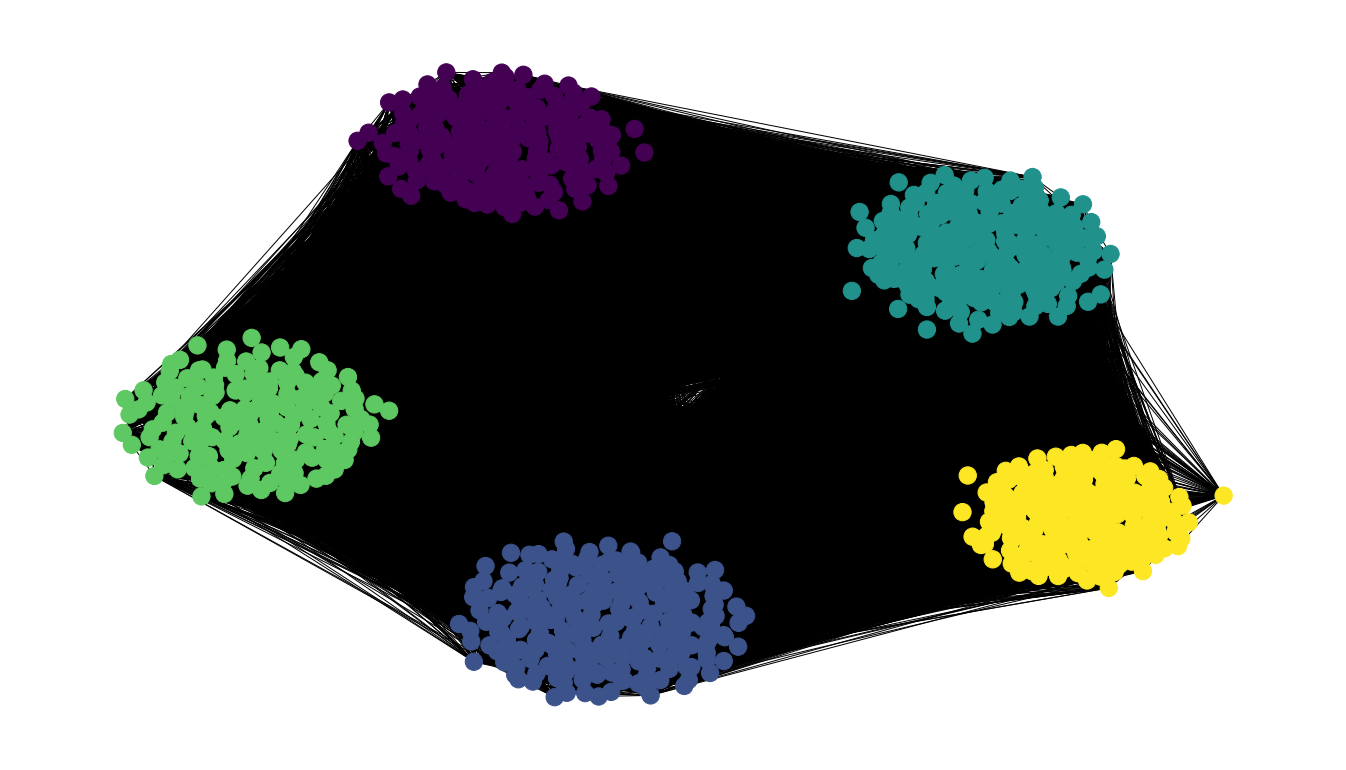

In [ ]:
if __name__ == "__main__":
  case = main()
  case_11_fully_known = case.case_11_fully_known()
  case_11_fully_known.summary()
  G = nx.from_numpy_matrix(case_11_fully_known.X)
  plot_sbm(G, case_11_fully_known, 0)

## case 20
DC-SBM, 3 classes

In [ ]:
if __name__ == "__main__":
  case = main()
  case_20 = case.case_20()
  case_20.summary()

Info:

    DC-SBM with 3 classes and defined probabilities with 95% unknown labels.
    
n:
<class 'int'>
3000
d:
<class 'int'>
3
X:
(3000, 3000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Y:
(3000, 1)
[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [-1]]


### fully-known

In [ ]:
if __name__ == "__main__":
  case = main()
  case_20_fully_known = case.case_20_fully_known()
  case_20_fully_known.summary()
  G = nx.from_numpy_matrix(case_20_fully_known.X)
  plot_sbm(G, case_20_fully_known, 0)

## case 21
DC-SBM, 10 classes

In [ ]:
if __name__ == "__main__":
  case = main()
  case_21 = case.case_21()
  case_21.summary()

Info:

    DC-SBM with 10 classes and defined probabilities with 95% unknown labels.
    Edge list version.     
    
n:
<class 'int'>
3000
d:
<class 'int'>
10
X:
(30487, 3)
[[   0    3    1]
 [   0  168    1]
 [   0  551    1]
 ...
 [2952 2993    1]
 [2975 2980    1]
 [2983 2987    1]]
Y:
(3000, 1)
[[-1]
 [-1]
 [-1]
 ...
 [-1]
 [-1]
 [ 5]]
